# This script will further assess the model performance

Written on 23/03/2023 by Claire S

I am testing the model out on a dataset that was labelled by the product team, and which has a big class imbalancew

In [35]:
from setfit import SetFitModel
import sys
import ipynb
import re
import pandas as pd
sys.path.append('/project/Xelix_Project/utils')
import numpy as np

In [36]:
from ipynb.fs.full.Regex_html_Functions import clean_websites, clean_fluff
# from ipynb.fs.full.Loop_Functions import sentence_by_sentence

In [37]:
# pandas options
pd.set_option('display.max_rows', 1000)
pd.set_option('display.max_columns', 1000)

In [38]:
%%time
# load trained model
model = SetFitModel._from_pretrained('trained_models/SetFit_Trained7')

CPU times: user 1.19 s, sys: 432 ms, total: 1.62 s
Wall time: 1.53 s


# This will run on the dataset labelled by the product team

In [39]:
# file_to_use = "data/labelled_emails.csv"
file_to_use = "data/Step2_Data/labelled_emails_filtered.csv"
# file_to_use = "data/hold_out_validation_set_bankchange.csv"

df = pd.read_csv(file_to_use)
print(len(df))
df.head()

347


,Unnamed: 0,iter_count_list,email_id,is_part_of_thread,num_in_thread,thread_id,initial_domain,from_address,from_name,sent_to,sent_to_how_many,bcc,cc,reply_to_address,internal_date,category_id,category_slug,has_sort_code,sort_code,has_attachment,mentions_bank,mentions_change,mentions_account_specifics,mentions_bank_account,subject_mentions_bank,subject_mentions_change,attachment_mentions_bank,mentions_statement,mentions_invoice,mentions_fraud,has_attention_ext_flag,has_alert_attach_flag,subject,attachments,email_text_body,final_label
0,34,13,186977,True,3,186977_t,evo-group.co.uk,mina.pasaloglou@evo-group.co.uk,mina.pasaloglou@evo-group.co.uk,"{Matt@tyronex.co.uk,Matt.Hales@evo-group.co.uk...",3,NaN,NaN,{},2021-09-14 10:07:55+00,35,bank-detail-change,False,NaN,False,True,False,False,False,True,True,False,True,False,False,False,False,RE: Tyronex Bank Account Change,NaN,"Hi Matt, Thank you for your email. Can you ...",0
1,35,13,186977,True,2,186977_t,evo-group.co.uk,Matt Tibble <Matt@tyronex.co.uk>,Matt Tibble <Matt@tyronex.co.uk>,"['Matt.Hales@evo-group.co.uk', 'Robert.Mitchel...",6,NaN,NaN,{},13 September 2021 10:17,35,bank-detail-change,False,NaN,False,True,False,False,True,True,True,NaN,False,False,False,True,True,FW: Tyronex Bank Account Change,NaN,Alert: There is currently a serious threat ...,1
2,36,13,186977,True,1,186977_t,evo-group.co.uk,Matt Tibble,Matt Tibble,"[' Matt.Hales@evo-group.co.uk ', ' Robert.Mitc...",5,NaN,NaN,{},13 September 2021 09:49,35,bank-detail-change,False,NaN,False,True,True,False,True,True,True,NaN,False,False,False,False,False,Tyronex Bank Account Change,NaN,Hi All Please find attached our new bank a...,1
3,120,69,250363,True,2,250363_t,evo-group.co.uk,Elaine.Robins@evo-group.co.uk,Elaine.Robins@evo-group.co.uk,"{Lisa.Dyson@evo-group.co.uk,Matt.Hales@evo-gro...",3,NaN,NaN,{},2022-02-22 09:49:57+00,43,new-supplier,False,NaN,False,True,True,False,False,False,True,False,False,False,False,False,False,FW: New Supplier - Valeo Foods Ireland,NaN,Good Morning Please see attached banking co...,0
4,417,356,282251,True,2,282251_t,precisionproco.co.uk,Simon.Hemingway@precisionproco.co.uk,Simon.Hemingway@precisionproco.co.uk,{purchase.ledger@evo-group.co.uk},1,NaN,NaN,{},2022-05-24 06:21:26+00,67,invoices-subject-line-pdf,False,NaN,False,True,True,False,True,False,False,False,False,True,True,True,False,FW: Invoice No. 666204,NaN,Attention: This email originated outside of ou...,0


In [40]:
df = df.rename(columns={"final_label":"label","email_text_body": "text"})
df["label_text"] = df.apply(lambda row: "positive" if row["label"] else "negative", axis = 1)
df.head(5)

,Unnamed: 0,iter_count_list,email_id,is_part_of_thread,num_in_thread,thread_id,initial_domain,from_address,from_name,sent_to,sent_to_how_many,bcc,cc,reply_to_address,internal_date,category_id,category_slug,has_sort_code,sort_code,has_attachment,mentions_bank,mentions_change,mentions_account_specifics,mentions_bank_account,subject_mentions_bank,subject_mentions_change,attachment_mentions_bank,mentions_statement,mentions_invoice,mentions_fraud,has_attention_ext_flag,has_alert_attach_flag,subject,attachments,text,label,label_text
0,34,13,186977,True,3,186977_t,evo-group.co.uk,mina.pasaloglou@evo-group.co.uk,mina.pasaloglou@evo-group.co.uk,"{Matt@tyronex.co.uk,Matt.Hales@evo-group.co.uk...",3,NaN,NaN,{},2021-09-14 10:07:55+00,35,bank-detail-change,False,NaN,False,True,False,False,False,True,True,False,True,False,False,False,False,RE: Tyronex Bank Account Change,NaN,"Hi Matt, Thank you for your email. Can you ...",0,negative
1,35,13,186977,True,2,186977_t,evo-group.co.uk,Matt Tibble <Matt@tyronex.co.uk>,Matt Tibble <Matt@tyronex.co.uk>,"['Matt.Hales@evo-group.co.uk', 'Robert.Mitchel...",6,NaN,NaN,{},13 September 2021 10:17,35,bank-detail-change,False,NaN,False,True,False,False,True,True,True,NaN,False,False,False,True,True,FW: Tyronex Bank Account Change,NaN,Alert: There is currently a serious threat ...,1,positive
2,36,13,186977,True,1,186977_t,evo-group.co.uk,Matt Tibble,Matt Tibble,"[' Matt.Hales@evo-group.co.uk ', ' Robert.Mitc...",5,NaN,NaN,{},13 September 2021 09:49,35,bank-detail-change,False,NaN,False,True,True,False,True,True,True,NaN,False,False,False,False,False,Tyronex Bank Account Change,NaN,Hi All Please find attached our new bank a...,1,positive
3,120,69,250363,True,2,250363_t,evo-group.co.uk,Elaine.Robins@evo-group.co.uk,Elaine.Robins@evo-group.co.uk,"{Lisa.Dyson@evo-group.co.uk,Matt.Hales@evo-gro...",3,NaN,NaN,{},2022-02-22 09:49:57+00,43,new-supplier,False,NaN,False,True,True,False,False,False,True,False,False,False,False,False,False,FW: New Supplier - Valeo Foods Ireland,NaN,Good Morning Please see attached banking co...,0,negative
4,417,356,282251,True,2,282251_t,precisionproco.co.uk,Simon.Hemingway@precisionproco.co.uk,Simon.Hemingway@precisionproco.co.uk,{purchase.ledger@evo-group.co.uk},1,NaN,NaN,{},2022-05-24 06:21:26+00,67,invoices-subject-line-pdf,False,NaN,False,True,True,False,True,False,False,False,False,True,True,True,False,FW: Invoice No. 666204,NaN,Attention: This email originated outside of ou...,0,negative


In [15]:

# # filter on the ones that are clear cases
# if 'final_label' in df.columns:
#     df = df.query("final_label != -1").reset_index(drop=True)
#     df = df.rename(columns={"final_label":"label","bank-detail-location": "bank_detail_loc"})
#     df["label_text"] = df.apply(lambda row: "positive" if row["label"] else "negative", axis = 1)
#     perc = (sum(df["label"])*100)/len(df)
#     print(f'true positives: {df["label"].sum()}, {"{:.1f}".format(perc)}%')
# else:
#     # rename some columns
#     df = df.rename(columns={"email_text_body":"text"})
#     df["label"] = df.apply(lambda row: 1 if row["category_id"] == 35 else 0, axis = 1)
#     df["label_text"] = df.apply(lambda row: "positive" if row["label"] else "negative", axis = 1)

# # shuffle and how much of this to take (frac = 1, shuffles and selects all)
# df = df.sample(frac=1)

# print(len(df))
# df.head(1)

In [16]:

# df = df.rename(columns={"email_text_body":"text"})
# # df["label"] = df.apply(lambda row: 1 if row["category_id"] == 35 else 0, axis = 1)
# df["label_text"] = df.apply(lambda row: "positive" if row["label"] else "negative", axis = 1)

# # shuffle and how much of this to take (frac = 1, shuffles and selects all)
# df = df.sample(frac=1)

# print(len(df))
# df.head(1)

# Run immediately

In [24]:
from ipywidgets import IntProgress
from IPython.display import display


# function for this loop
def sentence_by_sentence(df, model,save_prob=False):
    '''Classify the text of the emails in a sentence-by-sentence manner
    '''
    
    max_count = len(df)
    email_iter = 1

    if save_prob == True:
        sentence_cols = ['email_iter','email_id','num_in_thread',
                     'sentence','true_label','true_class','prob0','prob1','y_pred']
    else:
        sentence_cols = ['email_iter','email_id','num_in_thread',
                         'sentence','true_label','true_class','y_pred']
    
    df_list = []

    # to split the sentences by
    split_sentence_string = "[.?!]"
    
    f = IntProgress(min = 0, max = max_count)
    display(f)

    # change name of df here
    for email in df.itertuples():
        
        # try/except handling here
        try:

            clean_text = clean_websites(email.text)
            clean_text2 = clean_fluff(clean_text)
            sentences = re.split(split_sentence_string,clean_text2)

            # some counters
            email_iter += 1
            f.value = email_iter
            sum_score = 0

            len_email = len(sentences)

            for s in sentences:

                # check if this bit of the list is empty
                if len(s.strip()) == 0:
                    continue
                else:

#                     preds = model([s])
#                     this_label = preds.item()
#                     sum_score += this_label
                    
                    # display probabilities of each class
                    if save_prob == True:
                        proba = model.predict_proba([s])
                        probs = proba.tolist()
                    
                        prob0 = probs[0][0]
                        prob1 = probs[0][1]
                    
                        if prob0 > prob1:
                            this_label = 0
                        elif prob1 >= prob0:
                            this_label = 1
                        
                        sum_score += this_label
                        
                        # save row data
                        row_data = [email_iter, email.email_id, email.num_in_thread,
                                    s, email.label, email.label_text, prob0, prob1, this_label]
                        
                    else:

                        preds = model([s])
                        this_label = preds.item()
                        sum_score += this_label
                        
                        # save row data
                        row_data = [email_iter, email.email_id, email.num_in_thread,
                                    s, email.label, email.label_text, this_label]

                    df_row = pd.DataFrame([row_data],columns = sentence_cols)
                    df_list.append(df_row)

            ### save email sentence info
            sentence_df = pd.concat(df_list, ignore_index=True)

            ### save the meta email info
            perc_flag = "{:.1f}".format((sum_score*100)/len_email)

            # binary coding 
            y_pred = 1 if sum_score > 0 else 0
            diff = 0 if y_pred == email.label else 1
            
            # values to append to the big data frame
            df.at[email.Index,'email_iter'] = email_iter
            df.at[email.Index,'sum_score'] = sum_score
            df.at[email.Index,'len_email'] = len_email
            df.at[email.Index,'perc_flag'] = perc_flag
            df.at[email.Index,'y_pred'] = y_pred
            df.at[email.Index,'diff'] = diff
            
        except:
            print(f'error occurred at email_iter: {email_iter} email_id: {email.email_id} thread_id: {email.thread_id}')
#             logging.exception('')

    return sentence_df, df

In [41]:
%%time
email_df, meta_df = sentence_by_sentence(df, model, save_prob=True)

IntProgress(value=0, max=347)

CPU times: user 26min 6s, sys: 14.3 s, total: 26min 20s
Wall time: 15min 34s


In [52]:
sum(meta_df['y_pred'])

217.0

## Split the data up in batches

To avoid v long running time

In [5]:
# [batch_1, batch_2, batch_3,batch_4, batch_5,
#  batch_6,batch_7,batch_8, batch_9,batch_10]= np.array_split(this_df, 10)

In [6]:
# len(batch_1)

1797

In [7]:
# %%time
# _, meta_df1 = sentence_by_sentence(batch_1, model, save_prob=False)

IntProgress(value=0, max=1797)

error occurred at email_iter: 233 email_id: 287962 thread_id: 287962_t
CPU times: user 1h 9s, sys: 20.3 s, total: 1h 30s
Wall time: 1h 25s


# Save the different dataframes here

This is for running in batches on all the data

In [10]:
meta_df = meta_df1

In [11]:
df_list = []

In [12]:
this_meta = 'data/Step4_Data/labelled_data_meta_batch1.csv'
# this_email_df = 'data/Step4_Data/labelled_data_sentences_V2.csv'

In [13]:
meta_df.to_csv(this_meta)

In [9]:
print(len(meta_df))
print(pd.unique(meta_df['y_pred']))
meta_df['y_pred'].isnull().values.any()

347
[1. 0.]


False

In [53]:
meta_df_error = meta_df[meta_df['y_pred'].isnull()]
meta_df_error

,Unnamed: 0,iter_count_list,email_id,is_part_of_thread,num_in_thread,thread_id,initial_domain,from_address,from_name,sent_to,sent_to_how_many,bcc,cc,reply_to_address,internal_date,category_id,category_slug,has_sort_code,sort_code,has_attachment,mentions_bank,mentions_change,mentions_account_specifics,mentions_bank_account,subject_mentions_bank,subject_mentions_change,attachment_mentions_bank,mentions_statement,mentions_invoice,mentions_fraud,has_attention_ext_flag,has_alert_attach_flag,subject,attachments,text,label,label_text,email_iter,sum_score,len_email,perc_flag,y_pred,diff


In [59]:
meta_df = meta_df[meta_df['y_pred'].isnull()]
meta_df

,Unnamed: 0,iter_count_list,email_id,is_part_of_thread,num_in_thread,thread_id,initial_domain,from_address,from_name,sent_to,sent_to_how_many,bcc,cc,reply_to_address,internal_date,category_id,category_slug,has_sort_code,sort_code,has_attachment,mentions_bank,mentions_change,mentions_account_specifics,mentions_bank_account,subject_mentions_bank,subject_mentions_change,attachment_mentions_bank,mentions_statement,mentions_invoice,mentions_fraud,has_attention_ext_flag,has_alert_attach_flag,subject,attachments,text,label,label_text,email_iter,sum_score,len_email,perc_flag,y_pred,diff


In [55]:
meta_df_error = meta_df[meta_df['y_pred']].isna()
meta_df_error
# meta_df_error = meta_df[meta_df.isna().any(axis=1)]
# meta_df_error

""


# Inspect the true positives

In [31]:
# true_pos_ids = meta_df.loc[(meta_df['diff'] == 0) & (meta_df['y_pred'] == 1), 'email_iter']

# # filter the merged dataframe to keep only the rows where 'different' column is 1
# exps = email_df[email_df['email_iter'].isin(true_pos_ids)].reset_index(drop=True)

# # print the resulting dataframe
# print(len(true_pos_ids))
# print(len(exps))
# exps[0:1000]

# Inspect the false negatives

In [32]:
# false_negs_ids = meta_df.loc[(meta_df['diff'] == 1) & (meta_df['y_pred'] == 0), 'email_iter']
# # false_negs_ids = meta_df.loc[(meta_df['diff'] == 1), 'email_iter']

# # filter the merged dataframe to keep only the rows where 'different' column is 1
# exps = email_df[email_df['email_iter'].isin(false_negs_ids)].reset_index(drop=True)

# # print the resulting dataframe
# print(len(false_negs_ids))
# print(len(exps))
# exps[0:1000]

# Inspect the false positives

In [33]:
# false_pos_ids = meta_df.loc[(meta_df['diff'] == 1) & (meta_df['y_pred'] == 1), 'email_iter']
# # false_negs_ids = meta_df.loc[(meta_df['diff'] == 1), 'email_iter']

# # filter the merged dataframe to keep only the rows where 'different' column is 1
# exps = email_df[email_df['email_iter'].isin(false_pos_ids)].reset_index(drop=True)

# # print the resulting dataframe
# print(len(false_pos_ids))
# print(len(exps))
# exps[0:1000]

# Stats reporting

In [56]:
meta_df.columns

Index(['Unnamed: 0', 'iter_count_list', 'email_id', 'is_part_of_thread',
       'num_in_thread', 'thread_id', 'initial_domain', 'from_address',
       'from_name', 'sent_to', 'sent_to_how_many', 'bcc', 'cc',
       'reply_to_address', 'internal_date', 'category_id', 'category_slug',
       'has_sort_code', 'sort_code', 'has_attachment', 'mentions_bank',
       'mentions_change', 'mentions_account_specifics',
       'mentions_bank_account', 'subject_mentions_bank',
       'subject_mentions_change', 'attachment_mentions_bank',
       'mentions_statement', 'mentions_invoice', 'mentions_fraud',
       'has_attention_ext_flag', 'has_alert_attach_flag', 'subject',
       'attachments', 'text', 'label', 'label_text', 'email_iter', 'sum_score',
       'len_email', 'perc_flag', 'y_pred', 'diff'],
      dtype='object')

In [57]:
meta_df['y_pred'] = pd.to_numeric(meta_df['y_pred'])
meta_df['label'] = pd.to_numeric(meta_df['label'])

In [58]:
all_pos = meta_df.loc[(meta_df['label'] == 1)].shape[0]
all_neg = meta_df.loc[(meta_df['label'] == 0)].shape[0]
true_positives = meta_df.loc[(meta_df['label'] == 1) & (meta_df['y_pred'] == 1)].shape[0]
false_positives = meta_df.loc[(meta_df['label'] == 0) & (meta_df['y_pred'] == 1)].shape[0]
true_negatives = meta_df.loc[(meta_df['label'] == 0) & (meta_df['y_pred'] == 0)].shape[0]
false_negatives = meta_df.loc[(meta_df['label'] == 1) & (meta_df['y_pred'] == 0)].shape[0]

print(f'true pos: {true_positives}, false pos: {false_positives}, true negs: {true_negatives}, false negs: {false_negatives}')

true pos: 0, false pos: 0, true negs: 0, false negs: 0


In [27]:
meta_df['y_pred'].sum()

61.0

In [44]:
# Precision
precision = true_positives / (true_positives + false_positives)
# Precision
recall = true_positives / (true_positives + false_negatives)
# F1 score
f1 = 2 * ((recall * precision)/(recall + precision))

print(f'the model achieved a precision of {"{:.2f}".format(precision)}, recall of {"{:.2f}".format(recall)} and an F1 score of {"{:.2f}".format(f1)}')

the model achieved a precision of 0.07, recall of 1.00 and an F1 score of 0.14


# Check the ones that went wrong

In [50]:
all_bchange = meta_df.query('(final_label == 1)')
print(len(meta_df.query('(final_label == 1)')))

UndefinedVariableError: name 'final_label' is not defined

In [ ]:
i = 1
for row in all_bchange.itertuples():
    print("#" * 70, "\n\n")
    print(f'email index: {i}')
    i += 1
    print(f'subject line:\t{row.subject}')
    print(f'received from:\t{row.from_address}')
    print(f'is part of thread:\t{bool(row.is_part_of_thread)}')
    #print(f'num in thread:\t\t{int(row.num_in_thread)}')
    print(f'has attachment:\t\t{row.has_attachment}')
    print(f'has sort code:\t\t{row.has_sort_code}')
    print(f'mentions bank:\t\t{row.mentions_bank}')
    print(f'mentions b details:\t{row.mentions_account_specifics}')
    print(f'mentions change:\t{row.mentions_change}')
    print(f'subject mentions bank:\t{row.subject_mentions_bank}')
    print(f'subject mentions change:{row.subject_mentions_change}')
    #print(f'sent to:\t{row.sent_to}')
    print(f'sent to {row.sent_to_how_many} people')
    print(f'date sent:\t{row.internal_date}')
    print(f'slug:\t\t{row.category_slug}\n')
    print(row.email_text_body)

# Visualisation

In [29]:
from sklearn.metrics import auc, precision_recall_curve, confusion_matrix, ConfusionMatrixDisplay
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rcParams

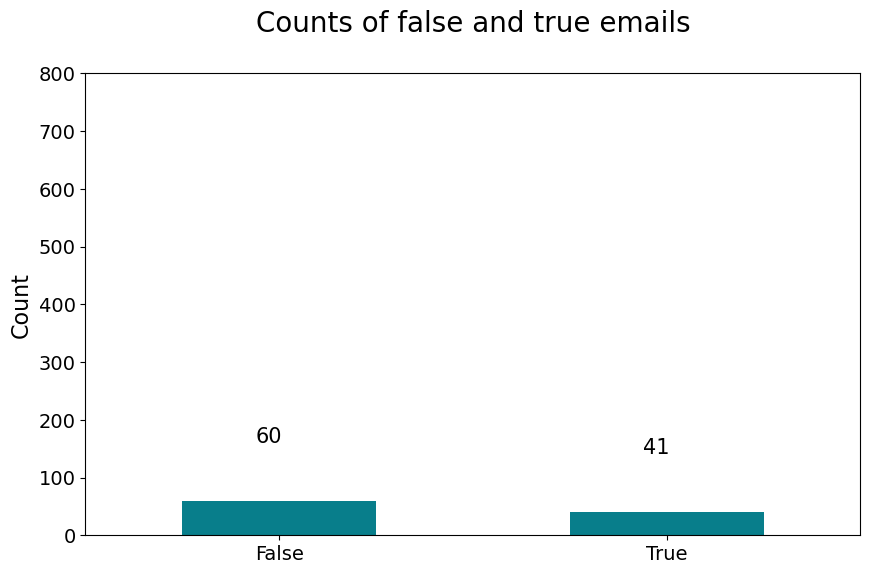

In [30]:
# barplots of the total values
ax = meta_df['label'].value_counts().plot(kind='bar', figsize=(10, 6), fontsize=13, color='#087E8B')
ax.set_title('Counts of false and true emails', size=20, pad=30)
ax.set_ylabel('Count', fontsize=16)
plt.ylim((0,800))
ax.set_xticklabels(["False", "True"],rotation = 0)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.style.use('seaborn-deep')

for i in ax.patches:
    ax.text(i.get_x() + 0.19, i.get_height() + 100, str(round(i.get_height(), 2)), fontsize=15)

In [31]:
# pd.unique(meta_df['y_pred'])
pd.unique(meta_df['label'])

array([1, 0])

In [17]:
meta_df.astype({'y_pred':'int'})
meta_df.astype({'label':'int'})

,Unnamed: 0,iter_count_list,email_id,is_part_of_thread,num_in_thread,thread_id,initial_domain,from_address,from_name,sent_to,sent_to_how_many,bcc,cc,reply_to_address,internal_date,category_id,category_slug,has_sort_code,sort_code,has_attachment,mentions_bank,mentions_change,mentions_account_specifics,mentions_bank_account,subject_mentions_bank,subject_mentions_change,attachment_mentions_bank,mentions_statement,mentions_invoice,mentions_fraud,has_attention_ext_flag,has_alert_attach_flag,subject,attachments,text,final_label,label,label_text,email_iter,sum_score,len_email,perc_flag,y_pred,diff
40,2116,1898,285447,False,0,False,premvan.com,Accounts@premvan.com,Accounts@premvan.com,{Matt.Hales@evo-group.co.uk},1,{},{},{Accounts@premvan.com},2022-05-31 15:58:36+00,100,invoices,True,"""09-02-22""",True,True,True,True,True,False,False,False,False,False,False,True,False,Premier Vanguard Invoice,Sales Invoice-VANGUARD_SINV00457583.PDF,Attention: This email originated outside of ...,0,0,negative,2.0,3.0,10.0,30.0,1.0,1.0
161,8096,7003,288799,False,0,False,sewellwallis.co.uk,Kirsty.Teather@sewellwallis.co.uk,Kirsty.Teather@sewellwallis.co.uk,{purchase.ledger@evo-group.co.uk},1,{},{},{},2022-06-13 10:08:54+00,1,statement,False,NaN,True,True,True,False,True,False,False,False,True,False,False,True,False,Overdue invoices,Statement for EVOGROUP As At 13Jun2022.pdf,Attention: This email originated outside of ou...,0,0,negative,3.0,1.0,8.0,12.5,1.0,1.0
249,13582,11785,306122,True,2,306122_t,evo-group.co.uk,Elaine.Robins@evo-group.co.uk,Elaine.Robins@evo-group.co.uk,"{Lisa.Dyson@evo-group.co.uk,Matt.Hales@evo-gro...",3,NaN,NaN,{},2022-07-28 13:43:57+00,43,new-supplier,False,NaN,False,True,True,False,False,False,True,False,False,False,False,False,False,FW: New Supplier - Intec Micros Ltd,NaN,Hi All Please see attached banking confirma...,0,0,negative,4.0,1.0,6.0,16.7,1.0,1.0
178,9269,8026,290244,False,0,False,tekseating.co.uk,Accounts@tekseating.co.uk,Accounts@tekseating.co.uk,{purchase.ledger@evo-group.co.uk},1,{},{},{},2022-06-16 09:33:04+00,67,invoices-subject-line-pdf,False,NaN,False,True,True,False,True,False,False,False,False,True,False,True,False,Sitsmart Invoice,NaN,Attention: This email originated outside of ou...,0,0,negative,5.0,0.0,6.0,0.0,0.0,0.0
210,11582,10076,291353,True,1,291353_t,banneruk.com,OM Binding Supplies Ltd <quickbooks@notificati...,OM Binding Supplies Ltd <quickbooks@notificati...,['Amy.Mitchell@banneruk.com'],1,NaN,NaN,{},20 June 2022 13:07,100,invoices,False,NaN,False,True,True,True,False,False,False,NaN,False,True,False,True,False,Invoice from OM Binding Supplies Ltd,NaN,Attention: This email originated outside of...,0,0,negative,6.0,0.0,26.0,0.0,0.0,0.0
314,16380,13037,383613,True,1,383613_t,claritas.com,Supplier.Administrator@scripps.com < Supplier...,Supplier.Administrator@scripps.com < Supplier...,[' billing@claritas.com '],1,NaN,NaN,{},"Friday, August 28, 2020 5:30 PM",133,demo,False,NaN,False,True,True,False,True,False,False,NaN,False,False,False,False,False,E.W. Scripps Supplier Workday Account,NaN,"Dear Billing Team , We would like to welcome ...",0,0,negative,7.0,1.0,12.0,8.3,1.0,1.0
224,12154,10575,291640,False,0,False,stericycle.com,ShreditUKinvoice@stericycle.com,ShreditUKinvoice@stericycle.com,"{purchase.ledger@evo-group.co.uk,accountspayab...",2,{},{},{},2022-06-21 06:22:54+00,67,invoices-subject-line-pdf,True,"""16-50-50""",True,True,True,True,True,False,False,False,False,True,False,True,False,"Shred-It Invoice # 9505384604 Jun 20,2022","2022.pdf,Shred-It Invoice # 9505384604 Jun 20",Attention: This email originated outside of ou...,0,0,negative,8.0,3.0,22.0,13.6,1.0,1.0
279,14947,12549,363456,True,11,363456_t,scripps.com,Mike.Daugherty@scripps.com,Mike.Daugherty@scripps.com,{Sarah.Jones@scripps.com},1,NaN,NaN,{},2021-09-23 15:44:41+00,47,other-queries,False,NaN,False,True,True,False,False,False,False,False,False,False,False,False,False,FW: document received,NaN,"Sarah, please update S-011061 to reflec

In [47]:
meta_df['y_pred'] = pd.to_int(meta_df['y_pred'])
meta_df['label'] = pd.to_numeric(meta_df['label'])

AttributeError: module 'pandas' has no attribute 'to_int'

In [48]:
y_actual = np.array(meta_df['label'])
y_pred = np.array(meta_df['y_pred'])

# print(y_actual)
# print(y_pred)

In [49]:
confusion_matrix = confusion_matrix(y_actual,y_pred)
cm_display = ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = [False, True])
cm_display.plot()
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()

TypeError: 'numpy.ndarray' object is not callable

In [ ]:
email_df

In [49]:
grouped = email_df.groupby(['email_id']).agg({'prob1': 'max'}).reset_index()
# grouped['y_pred_p'] = grouped['prob1'].apply(lambda x: 1 if x > 0.2 else 0)
grouped.head(10)

NameError: name 'email_df' is not defined

In [ ]:
meta_df = pd.merge(meta_df, grouped, on = 'email_id')


In [34]:
y_actual = meta_df['label']
y_probs = meta_df['prob1']

# baseline is ratio of positives and negatives
baseline_model = sum(y_actual) / len(y_actual)

precision, recall, _ = precision_recall_curve(y_actual, y_probs)
auc = auc(recall, precision)

KeyError: 'prob1'

In [ ]:
# plot it
plt.figure(figsize=(12, 7))
plt.plot([0, 1], [baseline_model, baseline_model], linestyle='--', linewidth = 1, label='Baseline model')
plt.plot(recall, precision, label=f'AUC (SetFit) = {auc:.2f}')
plt.title('Precision-Recall Curve', size=20, pad=30)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.xlabel('Recall', size=14)
plt.ylabel('Precision', size=14)
plt.style.use('seaborn-deep')
plt.legend();

In [2]:
pip install spacy

/bin/bash: /opt/anaconda/envs/Python3/lib/libtinfo.so.6: no version information available (required by /bin/bash)

         .:::.     .::.       
        ....yy:    .yy.       
        :.  .yy.    y.        
             :y:   .:         
             .yy  .:          
              yy..:           
              :y:.            
              .y.             
             .:.              
        ....:.                
        :::.                  

• Project files and data should be stored in /project. This is shared among everyone
  in the project.
• Personal files and configuration should be stored in /home/faculty.
• Files outside /project and /home/faculty will be lost when this server is terminated.
• Create custom environments to setup your servers reproducibly.

bash: /opt/anaconda/envs/Python3/lib/libtinfo.so.6: no version information available (required by bash)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.6/6.6 MB 36.9 MB/s eta 0:00:00:00:0100:01
  Using cached spacy_l

In [3]:
import spacy

2023-03-30 12:57:08.035761: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /opt/anaconda/envs/Python3/lib:
2023-03-30 12:57:08.035812: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2023-03-30 12:57:08.035845: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (cube-74b146d4-9002-47e9-94e5-93750346116a-69cb569d99-5cvlm): /proc/driver/nvidia/version does not exist


In [4]:
nlp = spacy.load(en_core_web_sm")

OSError: [E050] Can't find model 'en_core_web_sm'. It doesn't seem to be a Python package or a valid path to a data directory.